Error: File not found at QuantumYield_Data/Fluorescence Project/Resorcinol.1.0.csv


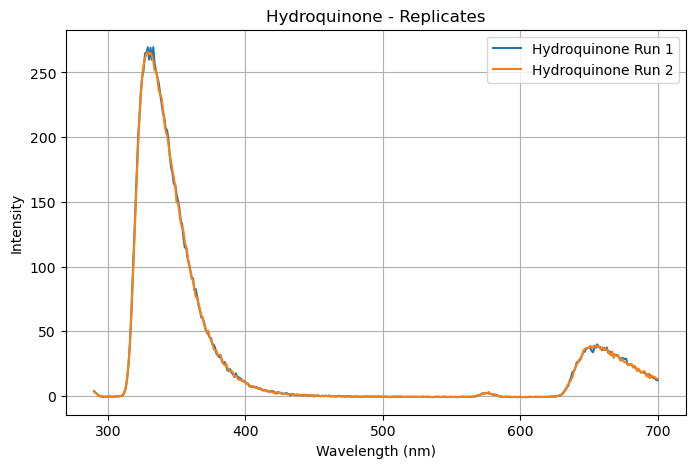

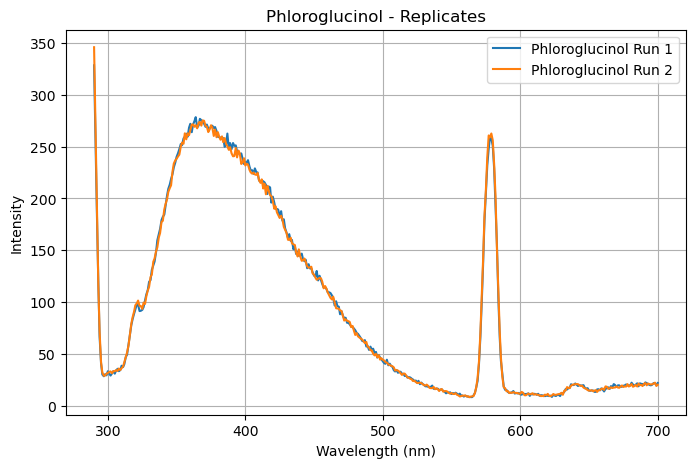

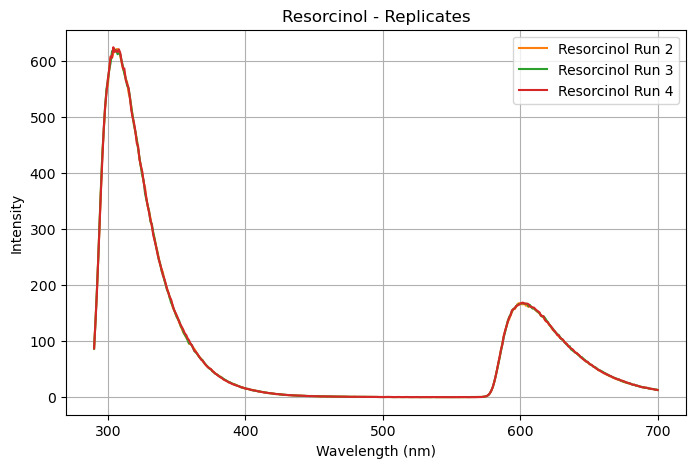

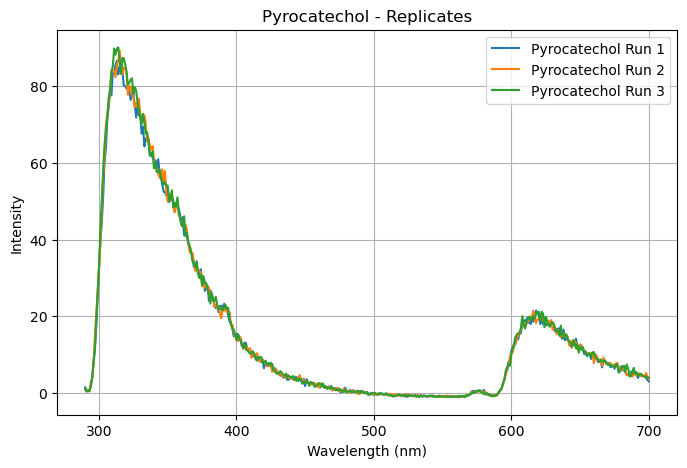

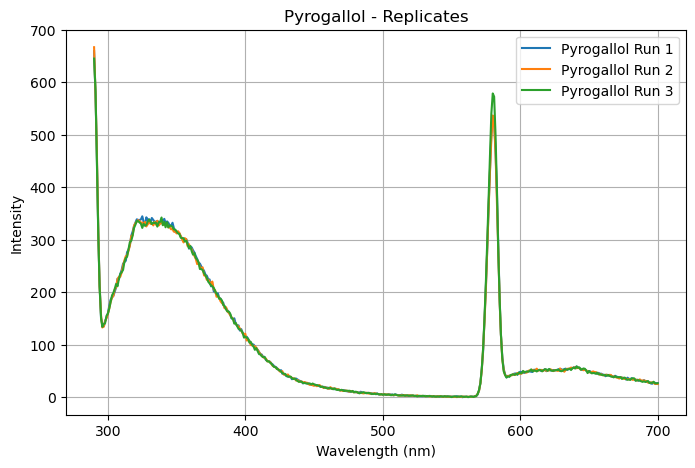

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
def load_csv(file_path):
    try:
        df = pd.read_csv(file_path, skiprows=1)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

    if df.shape[1] < 2:
        print(f"Error: File {file_path} does not contain at least two columns.")
        return None

    df = df.iloc[:, :2].dropna()
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors="coerce")
    df.iloc[:, 1] = pd.to_numeric(df.iloc[:, 1], errors="coerce")
    df.columns = ["Wavelength", "Intensity"]
    return df

# Function to load dilution data and scale relative to stock max intensity
def load_and_scale_dilution(file_path, stock_max):
    df = load_csv(file_path)
    if df is not None and stock_max > 0:
        df["Intensity"] /= stock_max  # Scale to stock max intensity
    return df


# Explicitly load each triplicate file for each compound, using correct filenames
base_path = "QuantumYield_Data/Fluorescence Project/"

# Hydroquinone: Hydroquinone_1_0.csv, Hydroquinone_1_1.csv, Hydroquinone_1_2.csv
hydroquinone_runs = [
    load_csv(base_path + "Hydroquinone_1_1.csv"),
    load_csv(base_path + "Hydroquinone_1_2.csv"),
]
# Phloroglucinol: Phloroglucinol_1_0.csv, Phloroglucinol_1_1.csv, Phloroglucinol_1_2.csv
phloroglucinol_runs = [
    load_csv(base_path + "Phloroglucinol_1_0.csv"),
    load_csv(base_path + "Phloroglucinol_1_2.csv"),
]
# Resorcinol: Resorcinol.1.0.csv, Resorcinol_1_1.csv, Resorcinol_1_2.csv, Resorcinol_1_3.csv
resorcinol_runs = [
    load_csv(base_path + "Resorcinol.1.0.csv"),
    load_csv(base_path + "Resorcinol_1_1.csv"),
    load_csv(base_path + "Resorcinol_1_2.csv"),
    load_csv(base_path + "Resorcinol_1_3.csv"),
]
# Pyrocatechol: Pyrocat_1_0.csv, Pyrocat_1_1.csv, Pyrocat_1_2.csv
pyrocatechol_runs = [
    load_csv(base_path + "Pyrocat_1_0.csv"),
    load_csv(base_path + "Pyrocat_1_1.csv"),
    load_csv(base_path + "Pyrocat_1_2.csv"),
]
# Pyrogallol: Pyrogal_1_0.csv, Pyrogal_1_1.csv, Pyrogal_1_2.csv
pyrogallol_runs = [
    load_csv(base_path + "Pyrogal_1_0.csv"),
    load_csv(base_path + "Pyrogal_1_1.csv"),
    load_csv(base_path + "Pyrogal_1_2.csv"),
]

# Plot all replicates together per compound, using correct compound names
compound_plot_data = [
    ("Hydroquinone", hydroquinone_runs),
    ("Phloroglucinol", phloroglucinol_runs),
    ("Resorcinol", resorcinol_runs),
    ("Pyrocatechol", pyrocatechol_runs),
    ("Pyrogallol", pyrogallol_runs),
]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for name, runs in compound_plot_data:
    plt.figure(figsize=(8, 5))
    for idx, run in enumerate(runs):
        if run is not None:
            plt.plot(run["Wavelength"], run["Intensity"], label=f"{name} Run {idx+1}", color=colors[idx % len(colors)])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.title(f"{name} - Replicates")
    plt.legend()
    plt.grid(True)
    plt.show()


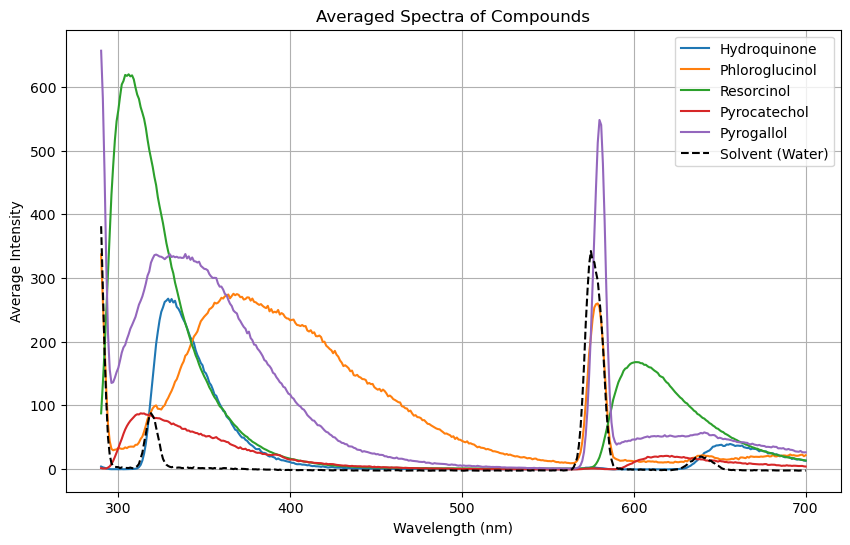

Saved Averaged_Spectra/Hydroquinone_Averaged.csv
Saved Averaged_Spectra/Phloroglucinol_Averaged.csv
Saved Averaged_Spectra/Resorcinol_Averaged.csv
Saved Averaged_Spectra/Pyrocatechol_Averaged.csv
Saved Averaged_Spectra/Pyrogallol_Averaged.csv
Saved Averaged_Spectra/Water_288_Averaged.csv


In [102]:
# --- New code to average intensities and plot all compounds together ---

# Load Water 288
water_run = load_csv(base_path + "Water 288_1_0.csv")

# Gather all wavelengths from all runs for all compounds to determine common wavelength grid
all_wavelengths = np.array([])
for _, runs in compound_plot_data:
    for run in runs:
        if run is not None:
            all_wavelengths = np.concatenate((all_wavelengths, run["Wavelength"].astype(float).values))
if water_run is not None:
    all_wavelengths = np.concatenate((all_wavelengths, water_run["Wavelength"].astype(float).values))
all_wavelengths = np.unique(all_wavelengths)

# Create a fine common wavelength grid
common_wavelength = np.arange(np.nanmin(all_wavelengths), np.nanmax(all_wavelengths) + 1, 1)


# Function to interpolate and average runs for a given list of DataFrames
def average_runs(runs, wavelength_grid):
    interp_intensities = []
    for run in runs:
        if run is not None:
            interp_intensity = np.interp(
                wavelength_grid,
                run["Wavelength"].astype(float),
                run["Intensity"].astype(float),
                left=np.nan,
                right=np.nan
            )
            interp_intensities.append(interp_intensity)
    if len(interp_intensities) == 0:
        return None
    stacked = np.vstack(interp_intensities)
    avg_intensity = np.nanmean(stacked, axis=0)
    return avg_intensity


# Average intensities per compound
averaged_data = []
for name, runs in compound_plot_data:
    avg_intensity = average_runs(runs, common_wavelength)
    averaged_data.append((name, avg_intensity))

# Interpolate Water 288 onto the common grid
if water_run is not None:
    water_interp = np.interp(
        common_wavelength,
        water_run["Wavelength"].astype(float),
        water_run["Intensity"].astype(float),
        left=np.nan,
        right=np.nan
    )
else:
    water_interp = None

# Plot all averaged curves together
plt.figure(figsize=(10, 6))
avg_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
for idx, (name, avg_intensity) in enumerate(averaged_data):
    if avg_intensity is not None:
        plt.plot(common_wavelength, avg_intensity, label=name, color=avg_colors[idx % len(avg_colors)])

# Plot Water 288
if water_interp is not None:
    plt.plot(common_wavelength, water_interp, label="Solvent (Water)", color="black", linestyle="--")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Intensity")
plt.title("Averaged Spectra of Compounds")
plt.legend()
plt.grid(True)
plt.show()

# Optionally save averaged spectra to CSV files
import os

output_folder = "Averaged_Spectra"
os.makedirs(output_folder, exist_ok=True)

for name, avg_intensity in averaged_data:
    if avg_intensity is not None:
        save_df = pd.DataFrame({
            "Wavelength (nm)": common_wavelength,
            "Average Intensity": avg_intensity
        })
        save_path = os.path.join(output_folder, f"{name}_Averaged.csv")
        save_df.to_csv(save_path, index=False)
        print(f"Saved {save_path}")

# Save Water 288
if water_interp is not None:
    water_df = pd.DataFrame({
        "Wavelength (nm)": common_wavelength,
        "Average Intensity": water_interp
    })
    water_path = os.path.join(output_folder, "Water_288_Averaged.csv")
    water_df.to_csv(water_path, index=False)
    print(f"Saved {water_path}")

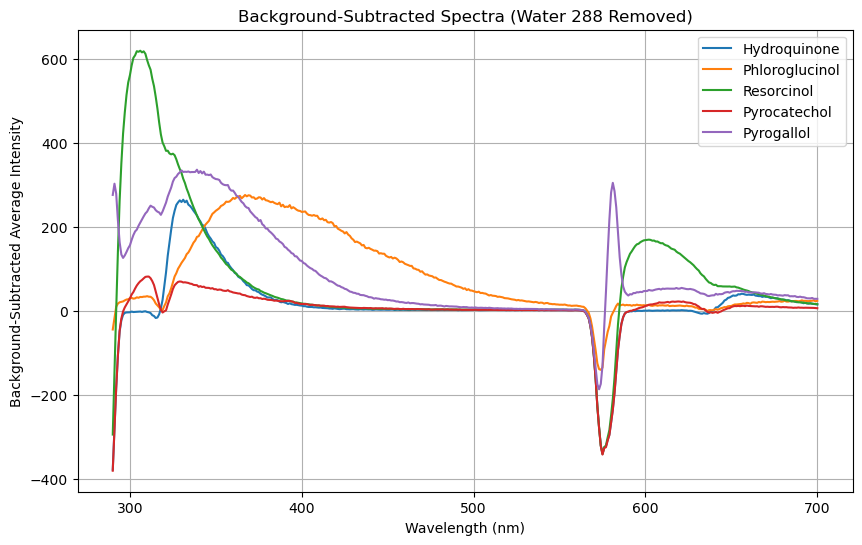

Saved Background_Subtracted_Spectra/Hydroquinone_Corrected.csv
Saved Background_Subtracted_Spectra/Phloroglucinol_Corrected.csv
Saved Background_Subtracted_Spectra/Resorcinol_Corrected.csv
Saved Background_Subtracted_Spectra/Pyrocatechol_Corrected.csv
Saved Background_Subtracted_Spectra/Pyrogallol_Corrected.csv


In [103]:

# --- New code to background subtract Water 288 and plot ---

# Subtract Water background from averaged compounds
background_subtracted_data = []
if water_interp is not None:
    for name, avg_intensity in averaged_data:
        if avg_intensity is not None:
            corrected_intensity = avg_intensity - water_interp
            background_subtracted_data.append((name, corrected_intensity))
else:
    background_subtracted_data = averaged_data  # If no water, fallback to original

# Plot background-subtracted curves
plt.figure(figsize=(10, 6))
for idx, (name, corrected_intensity) in enumerate(background_subtracted_data):
    if corrected_intensity is not None:
        plt.plot(common_wavelength, corrected_intensity, label=name, color=avg_colors[idx % len(avg_colors)])

plt.xlabel("Wavelength (nm)")
plt.ylabel("Background-Subtracted Average Intensity")
plt.title("Background-Subtracted Spectra (Water 288 Removed)")
plt.legend()
plt.grid(True)
plt.show()

# Save background-subtracted spectra to CSV files
output_folder_corrected = "Background_Subtracted_Spectra"
os.makedirs(output_folder_corrected, exist_ok=True)

for name, corrected_intensity in background_subtracted_data:
    if corrected_intensity is not None:
        corrected_df = pd.DataFrame({
            "Wavelength (nm)": common_wavelength,
            "Corrected Intensity": corrected_intensity
        })
        corrected_path = os.path.join(output_folder_corrected, f"{name}_Corrected.csv")
        corrected_df.to_csv(corrected_path, index=False)
        print(f"Saved {corrected_path}")

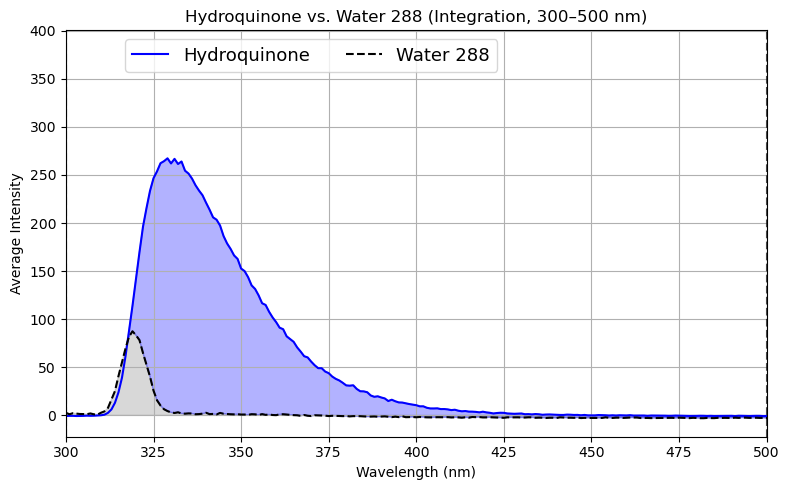

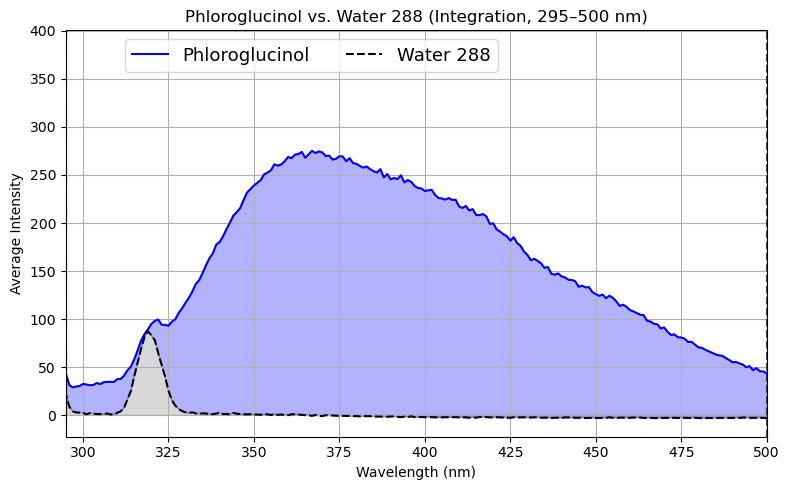

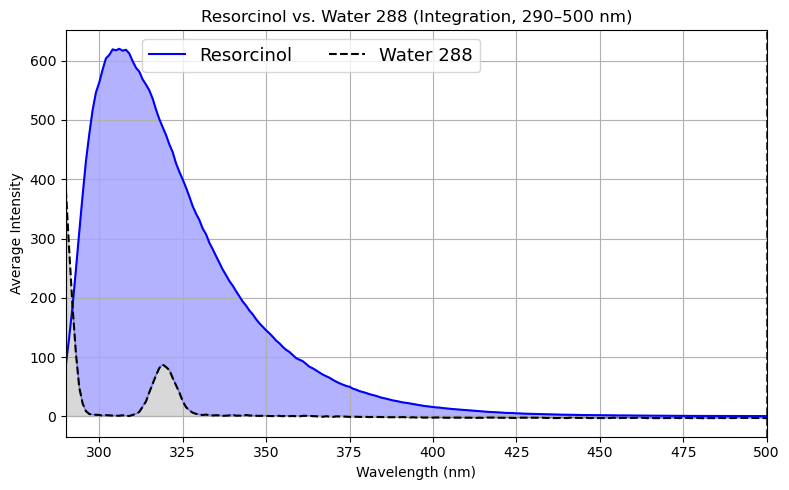

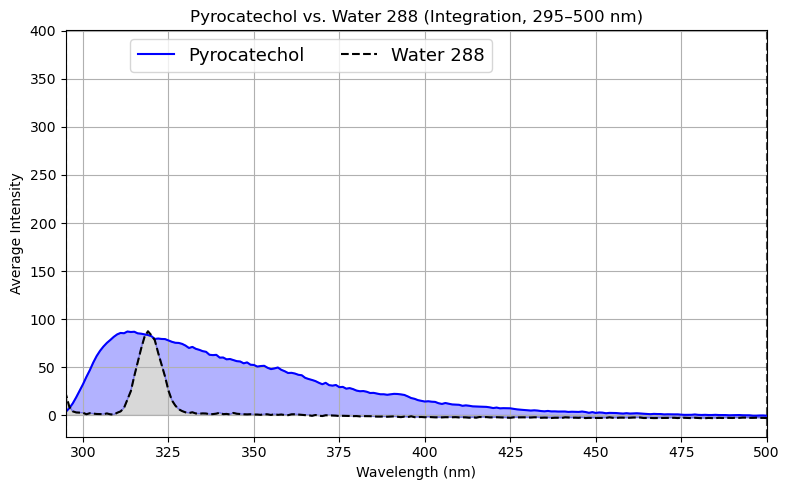

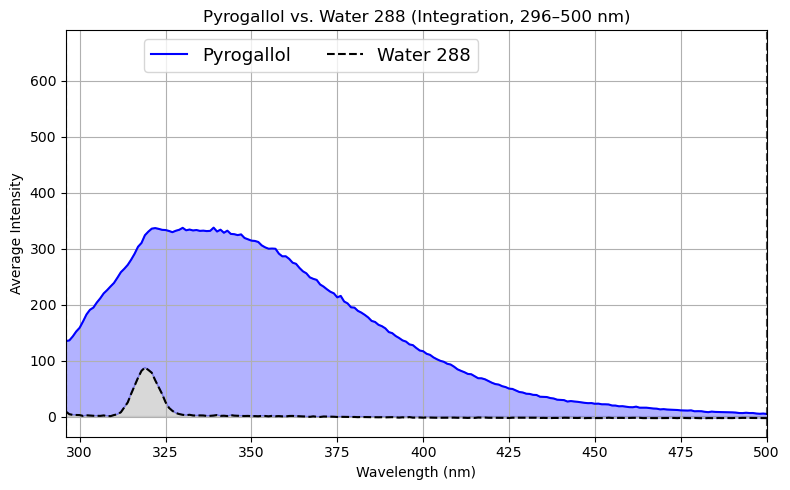

         Compound  Integration Start (nm)  Integration End (nm)      Net Area
0    Hydroquinone                     300                   500   9490.245565
1  Phloroglucinol                     295                   500  31301.580665
2      Resorcinol                     290                   500  25527.917653
3    Pyrocatechol                     295                   500   5015.960373
4      Pyrogallol                     296                   500  29084.343347


In [104]:
# --- Final clean block: Plot each averaged spectrum vs Water, shade areas, show 300–500 nm region, and integrate ---

# Integration bounds per compound (users can edit these)
integration_bounds = {
    "Hydroquinone": (300, 500),
    "Phloroglucinol": (295, 500),
    "Resorcinol": (290, 500),
    "Pyrocatechol": (295, 500),
    "Pyrogallol": (296, 500)
}

# Prepare results list
integrals = []

# Loop over each compound
for idx, (name, avg_intensity) in enumerate(averaged_data):
    if avg_intensity is None:
        continue

    x = common_wavelength
    y_comp = avg_intensity
    y_water = water_interp

    # Get integration bounds for this compound
    wl_min, wl_max = integration_bounds.get(name, (300, 500))

    # Restrict to compound-specific integration region
    mask = (x >= wl_min) & (x <= wl_max)
    x_range = x[mask]
    y_comp_range = y_comp[mask]
    y_water_range = y_water[mask]

    # Calculate difference and integral
    diff = y_comp_range - y_water_range
    net_area = np.trapz(diff, x_range)
    integrals.append({
        "Compound": name,
        "Integration Start (nm)": wl_min,
        "Integration End (nm)": wl_max,
        "Net Area": net_area
    })

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x, y_comp, label=f"{name}", color="blue")
    plt.plot(x, y_water, label="Water 288", color="black", linestyle="--")

    plt.fill_between(x, 0, y_water, color="gray", alpha=0.3)
    plt.fill_between(x, y_water, y_comp, where=(y_comp > y_water), interpolate=True,
                     color="blue", alpha=0.3)

    # Add vertical lines at integration bounds
    plt.axvline(x=wl_min, color="black", linestyle="--", alpha=0.7)
    plt.axvline(x=wl_max, color="black", linestyle="--", alpha=0.7)

    plt.legend( loc='upper center', fontsize= 13,
               bbox_to_anchor=(0.35, 1.00),  # shifted upward
               ncol=10, frameon=True)
    plt.xlim(wl_min, wl_max)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Average Intensity")
    plt.title(f"{name} vs. Water 288 (Integration, {wl_min}–{wl_max} nm)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display integration results nicely
integrals_df = pd.DataFrame(integrals)
print(integrals_df)

In [105]:
# Adjustment factors for molar concentration
adjustment_factors = {
    "Phloroglucinol": 1.11602007098,
    "Resorcinol": 0.994113158182,
    "Pyrogallol": 1.13026772434,
    "Hydroquinone": 1.1175245098,
    "Pyrocatechol": 1.0
}

# Apply corrections
corrected_integrals = []

for idx, row in integrals_df.iterrows():
    compound = row["Compound"]
    net_area = row["Net Area"]
    factor = adjustment_factors.get(compound, 1.0)

    # Special handling for Resorcinol (5 mg/mL initially)
    if compound == "Resorcinol":
        corrected_area = net_area * 2 * factor
    else:
        corrected_area = net_area * factor

    corrected_integrals.append({
        "Compound": compound,
        "Corrected Net Area": corrected_area
    })

# Create corrected table
corrected_integrals_df = pd.DataFrame(corrected_integrals)
print(corrected_integrals_df)

         Compound  Corrected Net Area
0    Hydroquinone        10605.582023
1  Phloroglucinol        34933.192275
2      Resorcinol        50755.277679
3    Pyrocatechol         5015.960373
4      Pyrogallol        32873.094569
